In [20]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import numpy as np
from configparser import ConfigParser

pd.options.display.float_format = lambda x: '{:,.1e}'.format(x) if x>1e6 else '{:,.2f}'.format(x)
pd.set_option('display.max_colwidth', None)
configFile='jc_report.config'
parser = ConfigParser()
parser.read(configFile)

h5_statistics = parser.get('JCReport', 'h5_statistics', fallback='jc_statistics.h5').split(',')
bed_names = parser.get('JCReport', 'bed_names', fallback='jc_statistics.h5').split(',')
prmNames=['run_id','pipeline_version',
          'bed_names', 'h5_statistics'
         ]

prm={}
for name in prmNames:
    prm[name]=parser.get('JCReport', name, fallback='NA')
    
h5outfile = parser.get('JCReport', 'h5_output', fallback='jc_report.h5')

prmdf = pd.DataFrame.from_dict(prm, orient='index',columns=['value']).reindex(prmNames)
prmdf.to_hdf(h5outfile, key="parameters")
prmdf

,value
run_id,ff
pipeline_version,1.1.5
bed_names,"wgn,high_conf,exome,extended_exome"
h5_statistics,"/data/mutect2/data_simulation/ff_wgn.h5,/data/mutect2/data_simulation/ff_high_conf.h5,/data/mutect2/data_simulation/ff_exome.h5,/data/mutect2/data_simulation/ff_extended_exome.h5"


In [21]:
import pandas as pd
def metric_table(h5_path, bed_name):
    #insertion_to_deletion_ratio
    meteric_table = pd.DataFrame(index=['novel','known','all'],columns=['nSNPs','nIndels','TiTv ratio','insertion-deletion ratio',
                                                                        'dbsnp snps ratio','dbsnp indels ratio',
                                                                        'biallelic snp ratio','biallelic indels ratio',
                                                                       'n_singleton_SNPs','n_singleton_indels'])
    indelSammary = pd.read_hdf(h5_path,'/eval_IndelSummary')
    meteric_table.loc['known','insertion-deletion ratio']=float(indelSammary.loc[indelSammary['Novelty']=='known','insertion_to_deletion_ratio'].values[0])
    meteric_table.loc['novel','insertion-deletion ratio']=float(indelSammary.loc[indelSammary['Novelty']=='novel','insertion_to_deletion_ratio'].values[0])
    meteric_table.loc['all','insertion-deletion ratio']=float(indelSammary.loc[indelSammary['Novelty']=='all','insertion_to_deletion_ratio'].values[0])
    #nSingleton
    meteric_table.loc['known','n_singleton_SNPs']=int(indelSammary.loc[indelSammary['Novelty']=='known','n_singleton_SNPs'].values[0])
    meteric_table.loc['novel','n_singleton_SNPs']=int(indelSammary.loc[indelSammary['Novelty']=='novel','n_singleton_SNPs'].values[0])
    meteric_table.loc['all','n_singleton_SNPs']=int(indelSammary.loc[indelSammary['Novelty']=='all','n_singleton_SNPs'].values[0])
    meteric_table.loc['known','n_singleton_indels']=int(indelSammary.loc[indelSammary['Novelty']=='known','n_singleton_indels'].values[0])
    meteric_table.loc['novel','n_singleton_indels']=int(indelSammary.loc[indelSammary['Novelty']=='novel','n_singleton_indels'].values[0])
    meteric_table.loc['all','n_singleton_indels']=int(indelSammary.loc[indelSammary['Novelty']=='all','n_singleton_indels'].values[0])
    #dnsnp_ratio
    variantSummary = pd.read_hdf(h5_path,'/eval_VariantSummary')
    meteric_table.loc['all','dbsnp snps ratio']=int(variantSummary.loc[variantSummary['Novelty']=='known','nSNPs'].values[0])/int(variantSummary.loc[variantSummary['Novelty']=='all','nSNPs'].values[0])
    meteric_table.loc['all','dbsnp indels ratio']=int(variantSummary.loc[variantSummary['Novelty']=='known','nIndels'].values[0])/int(variantSummary.loc[variantSummary['Novelty']=='all','nIndels'].values[0])
    # number of snps and indels
    meteric_table.loc['known','nSNPs']=int(variantSummary.loc[variantSummary['Novelty']=='known','nSNPs'].values[0])
    meteric_table.loc['novel','nSNPs']=int(variantSummary.loc[variantSummary['Novelty']=='novel','nSNPs'].values[0])
    meteric_table.loc['all','nSNPs']=int(variantSummary.loc[variantSummary['Novelty']=='all','nSNPs'].values[0])
    meteric_table.loc['known','nIndels']=int(variantSummary.loc[variantSummary['Novelty']=='known','nIndels'].values[0])
    meteric_table.loc['novel','nIndels']=int(variantSummary.loc[variantSummary['Novelty']=='novel','nIndels'].values[0])
    meteric_table.loc['all','nIndels']=int(variantSummary.loc[variantSummary['Novelty']=='all','nIndels'].values[0])
    #TiTvRatio
    meteric_table.loc['novel','TiTv ratio']=float(variantSummary.loc[variantSummary['Novelty']=='novel','TiTvRatio'].values[0])
    meteric_table.loc['known','TiTv ratio']=float(variantSummary.loc[variantSummary['Novelty']=='known','TiTvRatio'].values[0])
    meteric_table.loc['all','TiTv ratio']=float(variantSummary.loc[variantSummary['Novelty']=='all','TiTvRatio'].values[0])
    #MultiSnpRatio
    multiallelicSummary = pd.read_hdf(h5_path,'/eval_MultiallelicSummary')
    meteric_table.loc['known','biallelic snp ratio']=float(multiallelicSummary.loc[multiallelicSummary['Novelty']=='known','variantMultiSnpRatio'].values[0])
    meteric_table.loc['known','biallelic indels ratio']=float(multiallelicSummary.loc[multiallelicSummary['Novelty']=='known','variantMultiIndelRatio'].values[0])
    meteric_table.loc['novel','biallelic snp ratio']=float(multiallelicSummary.loc[multiallelicSummary['Novelty']=='novel','variantMultiSnpRatio'].values[0])
    meteric_table.loc['novel','biallelic indels ratio']=float(multiallelicSummary.loc[multiallelicSummary['Novelty']=='novel','variantMultiIndelRatio'].values[0])
    meteric_table.loc['all','biallelic snp ratio']=float(multiallelicSummary.loc[multiallelicSummary['Novelty']=='all','variantMultiSnpRatio'].values[0])
    meteric_table.loc['all','biallelic indels ratio']=float(multiallelicSummary.loc[multiallelicSummary['Novelty']=='all','variantMultiIndelRatio'].values[0])
    mi = pd.MultiIndex.from_tuples([(bed_name, itm) for itm in list(meteric_table.index)],names=['regions','metrics'])
    meteric_table.set_index(mi,inplace=True)
    return meteric_table

In [22]:
frames = []
for bed_name,h5_stat in zip(bed_names,h5_statistics):
    cur_result = metric_table(h5_stat, bed_name)
    frames.append(cur_result)
result = pd.concat(frames)
result

nSNPs nIndels TiTv ratio insertion-deletion ratio  \
regions        metrics                                                        
wgn            novel    1121028  244729       1.20                     0.51   
               known    2009048  160627       2.03                     0.57   
               all      3130076  405356       1.69                     0.54   
high_conf      novel     569819  131059       1.59                     0.55   
               known    1721761  125420       2.10                     0.63   
               all      2291580  256479       1.96                     0.59   
exome          novel       4025     903       1.44                     0.64   
               known      13420     117       3.10                     0.60   
               all        17445    1020       2.56                     0.63   
extended_exome novel      12669    3389       1.31                     0.61   
               known      35279    1630       2.45                     0.63   
               all        47948    5019       2.06                     0.61   

                       dbsnp snps ratio dbsnp indels ratio  \
regions        metrics                                       
wgn            novel                NaN                NaN   
               known                NaN                NaN   
               all                 0.64               0.40   
high_conf      novel                NaN                NaN   
               known                NaN                NaN   
               all                 0.75               0.49   
exome          novel                NaN                NaN   
               known                NaN                NaN   
               all                 0.77               0.11   
extended_exome novel                NaN                NaN   
               known                NaN                NaN   
               all                 0.74               0.32   

                       biallelic snp ratio biallelic indels ratio  \
regions        metrics                                              
wgn            novel                  0.10                   0.27   
               known                  0.02                   0.28   
               all                    0.05                   0.28   
high_conf      novel                  0.04                   0.14   
               known                  0.01                   0.22   
               all                    0.02                   0.18   
exome          novel                  0.05                   0.14   
               known                  0.01                   0.14   
               all                    0.02                   0.14   
extended_exome novel                  0.06                   0.17   
               known                  0.02                   0.17   
               all                    0.03                   0.17   

                       n_singleton_SNPs n_singleton_indels  
regions        metrics                                      
wgn            novel             600926             107776  
               known             506896              17990  
               all              1107822             125766  
high_conf      novel             445533              77902  
               known             449617              14623  
               all               895150              92525  
exome          novel               2796                501  
               known               5376                 23  
               all                 8172                524  
extended_exome novel               8318               1807  
               known              11817                226  
               all                20135               2033

# INDEL statistics

## Distribution of indel lengthsm

In [23]:
def ins_del_hete_graph(IndelLengthHistogram,ax, title=None):
    filtered_known_indel = indelLengthHistogram[indelLengthHistogram['Novelty']=='known']['Freq'].astype(float)
    filtered_novel_indel = indelLengthHistogram[indelLengthHistogram['Novelty']=='novel']['Freq'].astype(float)

    X = np.arange(20)
    ax.grid(False)
    ax.bar(X + 0.00, filtered_known_indel, color = 'r', width = 0.40)
    ax.bar(X + 0.40, filtered_novel_indel, color = 'mediumseagreen', width = 0.40)
    ax.set_title(title)
    ax.set_xticks(np.arange(0,20))
    ax.set_xticklabels([-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10])
    ax.legend(labels=['filtered_known_indel', 'filtered_novel_indel'])
    ax.set_xlabel('Indel Length')

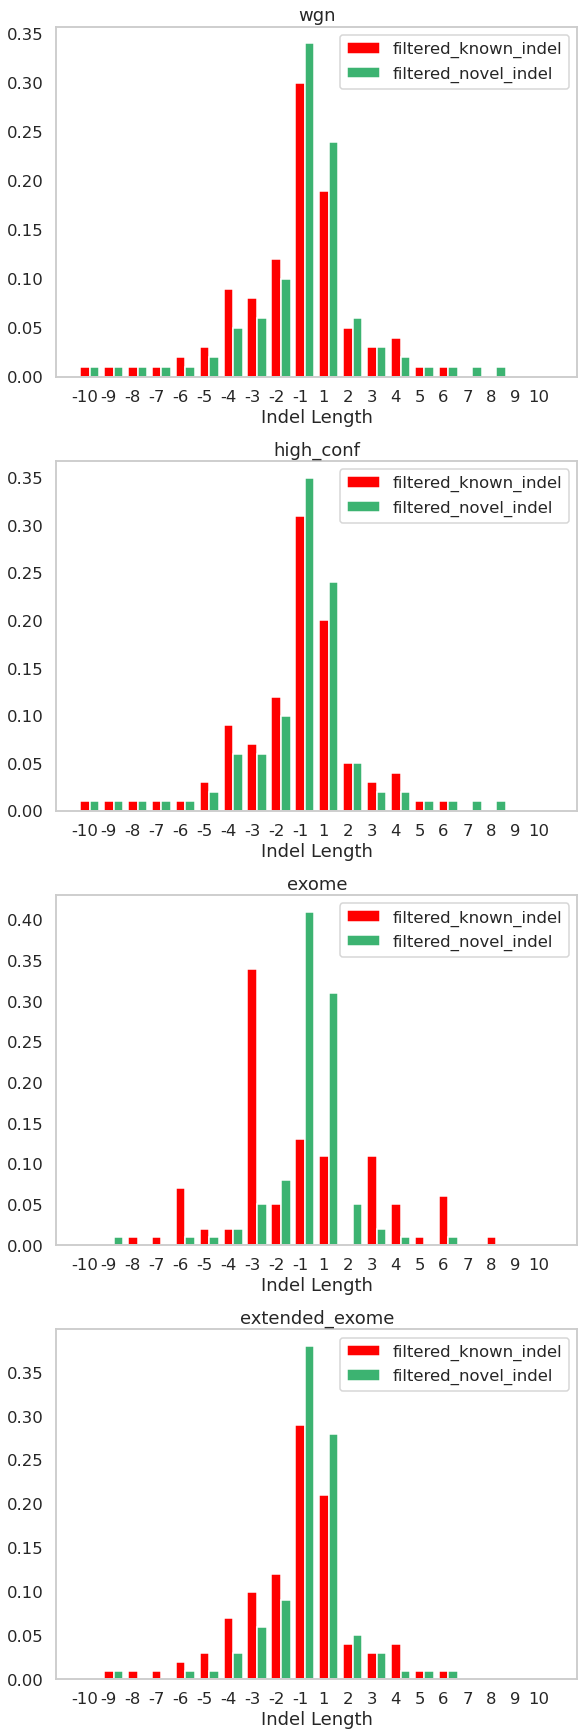

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
n = len(bed_names)
sns.set_context("talk")
sns.set_style("whitegrid")
fig, ax = plt.subplots(n,1,figsize=(8,6*n), constrained_layout=True)
for i,(bed_name,h5_stat) in enumerate(zip(bed_names, h5_statistics)) :
    indelLengthHistogram = pd.read_hdf(h5_stat,"/eval_IndelLengthHistogram")
    ins_del_hete_graph(indelLengthHistogram,ax[i],bed_name)

In [25]:
 #/home/ubuntu/miniconda3/envs/genomics.py3/bin/picard  IntervalListToBed INPUT=/data/wgs_calling_regions.hg38.interval_list OUTPUT=/data/wgs_calling_regions.hg38.bed

In [26]:
#!gsutil cp /data/wgs_calling_regions.hg38.bed gs://concordance/hg38/annotation_intervals/